## On Steam Games 

* This steam app project aims at understanding more about game types, game ratings, and the similarity. 
* The prediction on the game ratings has a relatively acceptable accuracy, reaching training error of 0.045461222106009884 and testing error of 0.10450519514048963. 
* Data can be found in https://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data

In [1]:
import json
import time
import ast
import collections
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
def get_users_aus(filename):
    users_db = {}
    time_start = time.time()
    sid_obj = SentimentIntensityAnalyzer() 
    
    for line in open(filename, 'r', encoding='utf-8'):
        user = ast.literal_eval(line)
        
        user_id = user['user_id'] 
        for i in range(len(user['reviews'])):
            
            product_id = user['reviews'][i]['item_id']
            text = user['reviews'][i]['review']
            rating = sid_obj.polarity_scores(text)['compound']
            recommend = user['reviews'][i]['recommend']
        
            if user_id not in users_db:
                users_db[user_id] = {}
            users_db[user_id][product_id] = {}
            users_db[user_id][product_id]['rating'] = rating
            users_db[user_id][product_id]['recommend'] = recommend
    
    time_end = time.time()
    print('Reading data: ' + str(time_end - time_start) + ' sec')
    return users_db

In [3]:
def get_items_db(filename):
    items_db = {}
    time_start = time.time()
    
    for line in open(filename, 'r', encoding='utf-8'):
        item = ast.literal_eval(line)
        
        if 'id' not in item or 'tags' not in item:
            continue
            
        item_id = item['id'] 
        genre_list = item['tags']
        
        items_db[item_id] = genre_list
        
    time_end = time.time()
    print('Reading data: ' + str(time_end - time_start) + ' sec')
    return items_db

In [4]:
users_db = get_users_aus("datasets/australian_user_reviews.json")

Reading data: 63.15352416038513 sec


In [5]:
items_db = get_items_db("datasets/steam_games.json")

Reading data: 2.4937798976898193 sec


In [6]:
correct_count = 0
false_count = 0
cannot_decide_count = 0

for user in users_db:
    for item in users_db[user]:
        rating = users_db[user][item]['rating']
        recommend = users_db[user][item]['recommend']
        if rating == 0:
            cannot_decide_count += 1
        elif (rating > 0 and recommend == True) or (rating < 0 and recommend == False):
            correct_count += 1
        else:
            false_count += 1
            
print('VADER accuracy (ignore 0):', correct_count / (correct_count + false_count))
print('VADER cannot decide rate:', cannot_decide_count/ (correct_count + false_count + cannot_decide_count))

VADER accuracy (ignore 0): 0.8077235349224524
VADER cannot decide rate: 0.17791925518988208


In [7]:
all_game = set()
for user in users_db:
    for item in users_db[user]:
        all_game.add(item)

In [8]:
exist_num = 0
not_exist_num = 0
for game in all_game:
    if game in items_db:
        exist_num += 1
    else:
        not_exist_num += 1

In [9]:
print('Game has type rate:', exist_num / (exist_num + not_exist_num))

Game has type rate: 0.8671917436175991


(array([13529.,  4629.,  2529.,  1499.,   980.,   736.,   551.,   419.,
          324.,   262.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

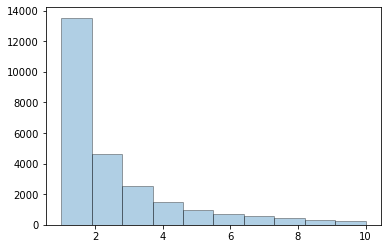

In [10]:
count = []
for i in users_db:
    count.append(len(users_db[i]))
plt.hist(count,edgecolor='k',alpha=0.35)

In [11]:
def get_user_to_rating_dict(users_db_name, user_based=True):
    item_set = set()
    user_to_rating = collections.defaultdict(dict)
    
    for user in users_db:
        for item in users_db[user]:
            if user_based:
                userId = user
                itemId = item
            else: # Hack for item-based method: Swap definition of user/item.
                userId = item
                itemId = user
            rating = users_db[user][item]['rating']

            user_to_rating[user][item] = rating
            item_set.add(item)

    return user_to_rating, item_set

In [12]:
user_to_rating, item_set = get_user_to_rating_dict(users_db)

**Split data into train and test, remove cannot count review**

In [13]:
user_clean = [((review,r), k) for k, v in user_to_rating.items() for review,r in v.items() if r!=0.0] #remove vader=0

In [14]:
train, test = train_test_split(list(user_clean), test_size=0.1)

In [15]:
def get_set(train):
    train_set=collections.defaultdict(dict)
    for i in train:       
        train_set[i[1]][i[0][0]] = i[0][1]
    return train_set

In [16]:
all_user = get_set(user_clean)

In [17]:
train_db = get_set(train)
test_db = get_set(test)

In [18]:
len(train) # make sure number of review is same

43231

In [19]:
count1 = []
for i in train_db:
    count1.append(len(train_db[i]))
sum(count1)

43231

In [20]:
len(test)

4804

In [21]:
count2 = []
for i in test_db:
    count2.append(len(test_db[i]))
sum(count2)

4804

In [22]:
train_id = [i for i in train_db]
test_id = [i for i in test_db]

In [23]:
train_item = [list(v.keys()) for user,v in train_db.items()]

In [24]:
test_item = [list(v.keys()) for user,v in test_db.items()]

**User_Base**

In [25]:
def get_user_to_rating_dict(users_db_name, user_based=True):
    item_set = set()
    user_to_rating = collections.defaultdict(dict)
    
    for user in users_db:
        for item in users_db[user]:
            if user_based:
                userId = user
                itemId = item
            else: # Hack for item-based method: Swap definition of user/item.
                userId = item
                itemId = user
            rating = users_db[user][item]['rating']

            user_to_rating[user][item] = rating
            item_set.add(item)

    return user_to_rating, item_set

def get_similarity_dict(db, id_list, similarity_func):
    # sim_db map user_id to its K_NEIGHBORS, sorted by similarity
    sim_db = {}
    n = 0
    # You could use tqdm to make a progressbar: https://github.com/tqdm/tqdm
    for target_user in id_list:
        sim_ary = []
        target_dict = db[target_user]
        for current_user in db:
            if current_user != target_user:
                current_dict = db[current_user]
                sim = similarity_func(target_dict, current_dict)
                if sim > 0:
                    sim_ary.append([current_user, sim])

        sim_ary.sort(key=lambda x: x[1], reverse=True)
        sim_db[target_user] = sim_ary
        n += 1
        if n % 500 == 0:
            print('finish', n)
    
    return sim_db

def cosine_similarity(d1, d2):
    common_key = d1.keys() & d2.keys() #intersection
    if len(common_key) > 0:
        dot = sum([d1[k] * d2[k] for k in common_key])
        norm1 = np.linalg.norm(list(d1.values())) #by default, L2 norm
        norm2 = np.linalg.norm(list(d2.values()))
        norm_12 = norm1 * norm2
        if norm_12 == 0:
            return 0.0
        else:
            sim = dot / norm_12
            return sim
    else:
        return 0.0

def centred_cosine_similarity(d1, d2):
    m1 = np.mean(list(d1.values()))
    m2 = np.mean(list(d2.values()))

    d1 = {k: v - m1 for k, v in d1.items()}
    d2 = {k: v - m2 for k, v in d2.items()}

    return cosine_similarity(d1, d2)

def pearson_similarity(d1, d2):
    common_key = d1.keys() & d2.keys()
    if len(common_key) >= 2:
        d1 = {k: v for k, v in d1.items() if k in common_key}
        d2 = {k: v for k, v in d2.items() if k in common_key}
        return centred_cosine_similarity(d1, d2)
    else:
        return 0.0

def predict_ratings(db, sim_db, movie_list, test_user_ids, N_TOP, K_NEIGHBORS):
    rec_db = {}
    
    for test_user_id in test_user_ids: # For each user in the test set **use train user**
        rec_ary = [] # List of recommended movies
        r_a = np.mean(list(db[test_user_id].values())) # See slides 21. Average rating for user a.
        #if db[test_user_id]=={}:
            #rec_ary.append([movie_id,average_score])
        #else:
        for movie_id in movie_list: # Predict rating for all unseen movies
            #if movie_id not in db[test_user_id]: #only predicts movies user don't have a rating 
            if movie_id in db[test_user_id]: # for train, we only predict the movies user had a rating
                num_ary = [] #each term in numerator
                den_ary = [] #each term in denominator
               
                for user_id, sim in sim_db[test_user_id]: # Compare all neighbors, until K_NEIGHBORS
                    if sim > 0: #Only consider positve similarity
             
                        r_ui = db[user_id].get(movie_id, None) #rating for user u for movie i
                        if r_ui is not None: #Has rating
                            r_u = np.mean([v for k, v in db[user_id].items() if k != movie_id]) #Average rating for user u. Exclude the movie being computed.

                            num_ary.append((r_ui - r_u) * sim)
                            den_ary.append(sim)
                            if len(den_ary) >= K_NEIGHBORS: #Stop once reach K_NEIGHBORS
                                    break

                if len(den_ary) == 0: #No other user have viewed this movie
                    p_ai = r_a
                else:
                    p_ai = r_a + sum(num_ary) / sum(den_ary)
                
                if p_ai > 1:
                    p_ai = 1
                elif p_ai < -1:
                    p_ai = -1
                #p_ai could be greater than 5! Because r_a could be already quite large (this user usually give high ratings)
                #You should clip the rating to [0.0, 5.0] via np.clip(p_ai, 0, 5)
                rec_ary.append([movie_id, p_ai])
            
        rec_ary.sort(key=lambda x: x[0], reverse=True) #for train, useing moveid to sort
        
        rec_db[test_user_id] = rec_ary #[:N_TOP] for prediction

    return rec_db


In [26]:
def predict_single_rate(db, sim_db, K_NEIGHBORS, user_id, item_id):
    r_a = np.mean(list(db[user_id].values()))
    num_ary = [] #each term in numerator
    den_ary = [] #each term in denominator
    if user_id not in sim_db:
        return 0.33
    for neighbor_user_id, sim in sim_db[user_id]: # Compare all neighbors, until K_NEIGHBORS
        r_ui = db[neighbor_user_id].get(item_id, None) #rating for user u for movie i
        if r_ui is not None: #Has rating
            r_u = np.mean([v for k, v in db[neighbor_user_id].items() if k != item_id]) #Average rating for user u. Exclude the movie being computed.
            num_ary.append((r_ui - r_u) * sim)
            den_ary.append(sim)
            if len(den_ary) >= K_NEIGHBORS: #Stop once reach K_NEIGHBORS
                break

    if len(den_ary) == 0: #No other user have viewed this movie
        p_ai = r_a
    else:
        p_ai = r_a + sum(num_ary) / sum(den_ary)

    if p_ai > 1:
        p_ai = 1
    elif p_ai < -1:
        p_ai = -1

    return p_ai

### train set

In [31]:
# tune paremeters N-top, K and sim_function
time_start = time.time()
SIM_FUNCTION = pearson_similarity

item_list = list(item_set)
item_list.sort()

sim_db = get_similarity_dict(train_db, train_id, SIM_FUNCTION)

time_end = time.time()
print('Reading data: ' + str(time_end - time_start) + ' sec')

finish 500
finish 1000
finish 1500
finish 2000
finish 2500
finish 3000
finish 3500
finish 4000
finish 4500
finish 5000
finish 5500
finish 6000
finish 6500
finish 7000
finish 7500
finish 8000
finish 8500
finish 9000
finish 9500
finish 10000
finish 10500
finish 11000
finish 11500
finish 12000
finish 12500
finish 13000
finish 13500
finish 14000
finish 14500
finish 15000
finish 15500
finish 16000
finish 16500
finish 17000
finish 17500
finish 18000
finish 18500
finish 19000
finish 19500
finish 20000
finish 20500
finish 21000
Reading data: 408.18937706947327 sec


In [40]:
K_NEIGHBORS = 50
SE = 0
n = 0
for user in train_db:
    for item in train_db[user]:
        pred_value = predict_single_rate(train_db, sim_db, K_NEIGHBORS, user, item)
        real_value = train_db[user][item]
        SE += (pred_value - real_value) ** 2
        n += 1

### train MSE

In [41]:
SE / n

0.12635184688184897

In [42]:
SE = 0
n = 0
for user in test_db:
    for item in test_db[user]:
        pred_value = predict_single_rate(train_db, sim_db, K_NEIGHBORS, user, item)
        real_value = test_db[user][item]
        SE += (pred_value - real_value) ** 2
        n += 1

### test MSE

In [43]:
SE / n

0.3611510920070702

In [46]:
all_id = [i for i in all_user]

### Prediction

In [44]:
def predict_ratings_2(db, sim_db, movie_list, test_user_ids, N_TOP, K_NEIGHBORS):
    rec_db = {}
    
    for test_user_id in test_user_ids: # For each user in the test set **use train user**
        rec_ary = [] # List of recommended movies
        r_a = np.mean(list(db[test_user_id].values())) # See slides 21. Average rating for user a.
        #if db[test_user_id]=={}:
            #rec_ary.append([movie_id,average_score])
        #else:
        for movie_id in movie_list: # Predict rating for all unseen movies
            if movie_id not in db[test_user_id]: #only predicts movies user don't have a rating 
            #if movie_id in db[test_user_id]: # for train, we only predict the movies user had a rating
                num_ary = [] #each term in numerator
                den_ary = [] #each term in denominator
               
                for user_id, sim in sim_db[test_user_id]: # Compare all neighbors, until K_NEIGHBORS
                    if sim > 0: #Only consider positve similarity
             
                        r_ui = db[user_id].get(movie_id, None) #rating for user u for movie i
                        if r_ui is not None: #Has rating
                            r_u = np.mean([v for k, v in db[user_id].items() if k != movie_id]) #Average rating for user u. Exclude the movie being computed.

                            num_ary.append((r_ui - r_u) * sim)
                            den_ary.append(sim)
                            if len(den_ary) >= K_NEIGHBORS: #Stop once reach K_NEIGHBORS
                                    break

                if len(den_ary) == 0: #No other user have viewed this movie
                    p_ai = r_a
                else:
                    p_ai = r_a + sum(num_ary) / sum(den_ary)
                
                if p_ai > 1:
                    p_ai = 1
                elif p_ai < -1:
                    p_ai = -1
                #p_ai could be greater than 5! Because r_a could be already quite large (this user usually give high ratings)
                #You should clip the rating to [0.0, 5.0] via np.clip(p_ai, 0, 5)
                rec_ary.append([movie_id, p_ai])
            
        rec_ary.sort(key=lambda x: x[0], reverse=True) #for train, useing moveid to sort
        
        rec_db[test_user_id] = rec_ary[:N_TOP] 

    return rec_db

In [47]:
sim_all = get_similarity_dict(all_user, all_id, SIM_FUNCTION)

finish 500
finish 1000
finish 1500
finish 2000
finish 2500
finish 3000
finish 3500
finish 4000
finish 4500
finish 5000
finish 5500
finish 6000
finish 6500
finish 7000
finish 7500
finish 8000
finish 8500
finish 9000
finish 9500
finish 10000
finish 10500
finish 11000
finish 11500
finish 12000
finish 12500
finish 13000
finish 13500
finish 14000
finish 14500
finish 15000
finish 15500
finish 16000
finish 16500
finish 17000
finish 17500
finish 18000
finish 18500
finish 19000
finish 19500
finish 20000
finish 20500
finish 21000
finish 21500
finish 22000


In [49]:
N_TOP = 5
prediction = predict_ratings_2(all_user, sim_all, item_list, all_id, N_TOP, K_NEIGHBORS)

In [51]:
import pandas as pd
result2 = pd.DataFrame(data=prediction)

In [53]:
result2 = result2.transpose()

In [55]:
result2.to_csv("user_base_result.csv")

**Content Base**

In [56]:
def get_itemId_to_genres(items_db):
    itemId_to_genres = {}

    for itemId in items_db:
        itemId_to_genres[itemId] = ''
        for genre in items_db[itemId]:
            if len(itemId_to_genres[itemId]) == 0:
                itemId_to_genres[itemId] += genre
            else:
                itemId_to_genres[itemId] += ('|' + genre)

    return itemId_to_genres

def get_items_meta_db(movieId_to_genres):
    index_to_movieId = {}
    movieId_to_index = {}
    genres_to_index = {}
    movies_genres_set_list = []
    index = 0

    for k in movieId_to_genres.keys():
        index_to_movieId[index] = k
        movieId_to_index[k] = index

        index += 1
        genres = movieId_to_genres[k].split('|')
        genres_set = set()
        for genre in genres:
            if genre not in genres_to_index.keys():
                genres_to_index[genre] = len(genres_to_index)
            genres_set.add(genres_to_index[genre])
        movies_genres_set_list.append(genres_set)

    return index_to_movieId, movieId_to_index, genres_to_index, movies_genres_set_list

def get_ratings_meta_db(users_db):
    userId_to_itemId = {}
    userId_itemId_to_rating = {}
    userId_to_sum_count = {}
    
    for user in users_db:
        userId_to_itemId[user] = []
        userId_to_sum_count[user] = [0, 0]
        for item in users_db[user]:
            rating = users_db[user][item]['rating']
            
            userId_to_itemId[user].append(item)
            userId_itemId_to_rating[(user, item)] = rating
            userId_to_sum_count[user][0] += rating
            userId_to_sum_count[user][1] += 1
            
    return userId_to_itemId, userId_itemId_to_rating, userId_to_sum_count

def get_hash_coeffs(br):
    rnds = np.random.choice(2**8, (2, br), replace=False)
    c = 347 
    return rnds[0], rnds[1], c

def min_hashing(shingles, hash_coeffs, br):
    count = len(shingles)
    (a, b, c) = hash_coeffs
    a = a.reshape(1, -1)
    M = np.zeros((br, count), dtype=int) #Its layout same as slide 56. col are docs, row are signature index
    for i, s in enumerate(shingles):
        # All shingles in the document
        row_idx = np.asarray(list(s)).reshape(-1, 1)
        # Instead of getting many hash functions and run each hash function to each shingles,
        # Use numpy matrix multiplication to apply all hash funcitons to all shingles in the same time
        m = (np.matmul(row_idx, a) + b) % c
        m_min = np.min(m, axis=0) #For each hash function, minimum hash value for all shingles
        M[:, i] = m_min

    return M

def LSH(M, b, r, band_hash_size):
    count = M.shape[1]

    bucket_list = []
    for band_index in range(b):
        # The hash table for each band is stored as a dictionrary of sets. It's more efficient than sparse matrix
        m = collections.defaultdict(set)

        row_start = band_index * r
        for c in range(count):
            v = M[row_start:(row_start+r), c]
            v_hash = hash(tuple(v.tolist())) % band_hash_size
            m[v_hash].add(c)

        bucket_list.append(m)

    return bucket_list

def get_similar_moiveIndex_set(movieIndex):
    similar_set = set()
    for i in range(0, len(bucket_list)):
        cur_bucket = bucket_list[i]
        bucketIndex = itemIndex_to_bucketIndex[i][movieIndex]
        for num in cur_bucket[bucketIndex]:
            similar_set.add(num)
    return similar_set

def content_based_pred_rate(userId, movieId, userId_to_moiveId, userId_to_sum_count, userId_moiveId_to_rating, movieId_to_index, M):
    summation = 0
    sim_sum = 0
    if movieId in movieId_to_index:
        movieIndex_predict = movieId_to_index[movieId]
        similar_set = get_similar_moiveIndex_set(movieIndex_predict)
    
        for seen_id in userId_to_moiveId[userId]:
            if seen_id in movieId_to_index:
                seen_index = movieId_to_index[seen_id]
                if seen_index not in similar_set:
                    continue
                seen_rate = userId_moiveId_to_rating[(userId, seen_id)]
            
                movie_index = movieId_to_index[movieId]
                c1 = M[:, seen_index]
                c2 = M[:, movie_index]
                sim = np.mean(c1 == c2)

                summation += sim * seen_rate
                sim_sum += sim
                
    
            if sim_sum == 0:
                return userId_to_sum_count[userId][0] / userId_to_sum_count[userId][1]
    
            pred_rating = summation / sim_sum   
    
            if pred_rating > 1:
                return 1
            elif pred_rating < -1:
                return -1
            else:
                return pred_rating 
    else:
        return userId_to_sum_count[userId][0] / userId_to_sum_count[userId][1]

In [57]:
itemId_to_genres = get_itemId_to_genres(items_db)
index_to_itemId, itemId_to_index, genres_to_index, genres_set_list = get_items_meta_db(itemId_to_genres)

In [118]:
band_hash_size = 2**13
b = 15
r = 5
br = b * r

hash_coeffs = get_hash_coeffs(br)
M = min_hashing(genres_set_list, hash_coeffs, br)
bucket_list = LSH(M, b, r, band_hash_size)

itemIndex_to_bucketIndex = []
for i in range(len(bucket_list)):
    itemIndex_to_bucketIndex.append({})
    cur_bucket_list = bucket_list[i]
    for key in cur_bucket_list:
        cur_bucket = cur_bucket_list[key]
        for item_index in cur_bucket:
            itemIndex_to_bucketIndex[i][item_index] = key
            

**split train set & test set for content base**

In [119]:
user_clean_db = [((review,r), k) for k, v in users_db.items() for review,r in v.items() if r['rating']!=0.0] #remove vader=0

In [120]:
train2, test2 = train_test_split(list(user_clean_db), test_size=0.1)

In [121]:
def get_set_2(train):
    train_set = collections.defaultdict(dict)
    for i in train:
        train_set[i[1]][i[0][0]]={}
        train_set[i[1]][i[0][0]]['rating']=i[0][1]['rating']
        train_set[i[1]][i[0][0]]['recommend']=i[0][1]['recommend']
    return train_set

In [122]:
train_set2 = get_set_2(train2)
test_set2 = get_set_2(test2)
train2_id = [i for i in train_set2]
userId_to_itemId, userId_itemId_to_rating, userId_to_sum_count = get_ratings_meta_db(train_set2)

In [123]:
content_based_pred_rate('euzi', '767400', userId_to_itemId, userId_to_sum_count, userId_itemId_to_rating, itemId_to_index, M)

In [124]:
user_to_rating2, item_set2 = get_user_to_rating_dict(train_set2,user_based=False)
item_list2 = list(item_set2)

In [125]:
item_list = list(item_set)
item_list.sort()
N_TOP = 5
ratings = {}
for userId in train2_id:
    rec_ary = []
    for movieId in item_list2:
        if movieId in train_set2[userId]: #for train, for prediction use not in
            rating=content_based_pred_rate(userId, movieId, userId_to_itemId, userId_to_sum_count, userId_itemId_to_rating, itemId_to_index, M)
            rec_ary.append([movieId, rating])

    #rec_ary.sort(key=lambda x: x[1], reverse=True)
    ratings[userId] = rec_ary #rec_ary[:N_TOP] for prediction
        

In [126]:
for i in ratings:
    ratings[i] = sorted(dict(ratings[i]).items())

In [127]:
for i in train_set2:
    train_set2[i] = sorted(train_set2[i].items())

In [128]:
r_pred = []
for i in ratings:
    for r in ratings[i]:
        r_pred.append(r[1])

In [129]:
r_acutal = []
for i in train_set2:
    for r in train_set2[i]:
        r_acutal.append(r[1]['rating'])

In [130]:
print('train set error={}'.format(mean_squared_error(r_pred, r_acutal)))

train set error=0.045461222106009884


**test set**

In [131]:
test_set2 = get_set_2(test2)
test2_id = [i for i in test_set2]
userId_to_itemId2, userId_itemId_to_rating2, userId_to_sum_count2 = get_ratings_meta_db(test_set2)
#user_to_rating, item_set = get_user_to_rating_dict(test_set2,user_based=False)
#item_list = list(item_set)
#item_list.sort()

In [132]:
N_TOP = 5
ratings2 = {}
average_score = 0.333
for userId in test2_id:
    rec_ary2 = []
    for movieId in item_list:
        if movieId in test_set2[userId]:
            if userId in userId_to_sum_count:
                rating2=content_based_pred_rate(userId, movieId, userId_to_itemId2, userId_to_sum_count, userId_itemId_to_rating2, itemId_to_index, M)
                rec_ary2.append([movieId, rating2])
            else:
                rec_ary2.append([movieId,average_score])
    #rec_ary.sort(key=lambda x: x[1], reverse=True)
    ratings2[userId] = rec_ary2 #rec_ary[:N_TOP] for prediction

In [133]:
for i in ratings2:
    ratings2[i] = sorted(dict(ratings2[i]).items())

In [134]:
for i in test_set2:
    test_set2[i] = sorted(test_set2[i].items())

In [135]:
r_pred2 = []
for i in ratings2:
    for r in ratings2[i]:
        r_pred2.append(r[1])

In [136]:
r_acutal2 = []
for i in test_set2:
    for r in test_set2[i]:
        r_acutal2.append(r[1]['rating'])

In [137]:
print('test set error={}'.format(mean_squared_error(r_pred2, r_acutal2)))

test set error=0.10450519514048963


**Prediction**

In [138]:
all_set = get_set_2(user_clean_db)
all_id = [i for i in all_set]
userId_to_itemId, userId_itemId_to_rating, userId_to_sum_count = get_ratings_meta_db(all_set)
N_TOP = 5
item_list = list(item_set)
prediction = {}
average_score = 0.333
for userId in all_id:
    rec = []
    for movieId in item_list:
        if movieId not in all_set[userId]:
            if userId in userId_to_sum_count:
                rating2=content_based_pred_rate(userId, movieId, userId_to_itemId, userId_to_sum_count, userId_itemId_to_rating, itemId_to_index, M)
                rec.append([movieId, rating2])
            else:
                rec.append([movieId,average_score])
    #rec_ary.sort(key=lambda x: x[1], reverse=True)
    prediction[userId] = rec[:N_TOP] 